In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
bike_df=pd.read_csv('data/bike.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [4]:
bike_df['datetime']=bike_df.datetime.apply(pd.to_datetime)

bike_df['year']=bike_df.datetime.apply(lambda x: x.year)
bike_df['month']=bike_df.datetime.apply(lambda x: x.month)
bike_df['day']=bike_df.datetime.apply(lambda x: x.day)
bike_df['hour']=bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [5]:
bike_df.drop(['datetime','casual','registered'],axis=1,inplace=True)

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def rmsle(y,pred):
    log_y=np.log1p(y)
    log_pred=np.log1p(pred)
    squared_error=(log_y-log_pred)**2
    rmsle=np.sqrt(np.mean(squared_error))
    return rmsle
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))
def evaluate_regr(y,pred):
    rmsle_val=rmsle(y,pred)
    rmse_val=rmse(y,pred)
    mae_val=mean_absolute_error(y,pred)
    print('RMSLE : {:.4f} RMSE : {:.4f} MAE : {:.4f}'.format(rmsle_val,rmse_val,mae_val))
    

In [7]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
y_target=bike_df['count']
X_features=bike_df.drop('count',axis=1,inplace=False)
X_train,X_test,y_train,y_test=train_test_split(X_features,y_target,test_size=0.3,random_state=0)
lr_reg=LinearRegression()
lr_reg.fit(X_train,y_train)
pred=lr_reg.predict(X_test)
evaluate_regr(y_test,pred)

RMSLE : 1.1647 RMSE : 140.8996 MAE : 105.9244


In [8]:
def get_top_error_data(y_test,pred,n_tops=5):
    result_df=pd.DataFrame(y_test.values,columns=['real_count'])
    result_df['predicted_count']=np.round(pred)
    result_df['diff']=np.abs(result_df['real_count']-result_df['predicted_count'])
    
    print(result_df.sort_values('diff',ascending=False)[:n_tops])
get_top_error_data(y_test,pred)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


(array([ 237.,  462.,  625.,  626.,  805., 1076., 1768., 2544., 2058.,
         685.]),
 array([0.69314718, 1.31238343, 1.93161968, 2.55085593, 3.17009218,
        3.78932843, 4.40856467, 5.02780092, 5.64703717, 6.26627342,
        6.88550967]),
 <a list of 10 Patch objects>)

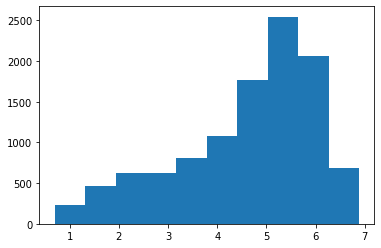

In [9]:
plt.hist(np.log1p(y_target))

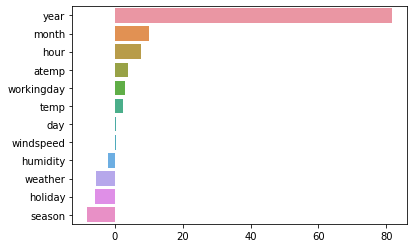

In [11]:
coef=pd.Series(lr_reg.coef_,index=X_features.columns)
coef_sort=coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values,y=coef_sort.index)


In [14]:
X_features_ohe=pd.get_dummies(X_features,columns=['year','month','hour','holiday','workingday','season','weather'])

In [18]:
y_target_log=np.log1p(y_target)

In [21]:
X_train,X_test,y_train,y_test=train_test_split(X_features_ohe,y_target_log,test_size=0.3,random_state=0)

def get_model_predict(model,X_train,X_test,y_train,y_test,is_expm1=False):
    model.fit(X_train,y_train)
    pred=model.predict(X_test)
    if is_expm1:
        y_test=np.expm1(y_test)
        pred=np.expm1(pred)
    print("###",model.__class__.__name__,"###")
    evaluate_regr(y_test,pred)
lr_reg=LinearRegression()
ridge_reg=Ridge(alpha=10)
lasso_reg=Lasso(alpha=0.01)

for model in [lr_reg,ridge_reg,lasso_reg]:
    get_model_predict(model,X_train,X_test,y_train,y_test,is_expm1=True)

### LinearRegression ###
RMSLE : 0.5889 RMSE : 97.4842 MAE : 63.1059
### Ridge ###
RMSLE : 0.5895 RMSE : 98.4069 MAE : 63.6483
### Lasso ###
RMSLE : 0.6344 RMSE : 113.0309 MAE : 72.6582


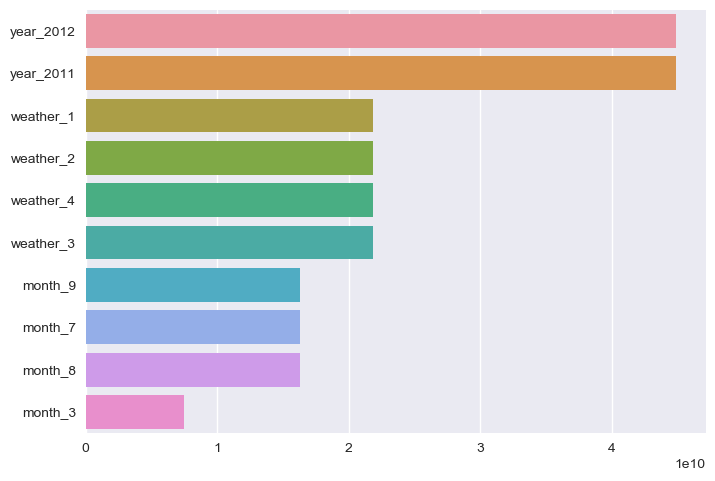

In [29]:
coef=pd.Series(lr_reg.coef_,index=X_features_ohe.columns)
coef_sort=coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values,y=coef_sort.index)
plt.style.use('seaborn')